In [1]:
!pip install simfin

     |████████████████████████████████| 60 kB 3.5 MB/s 


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [ ]:
# Version of the SimFin Python API.
sf.__version__

'0.8.4'

In [3]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

# SimFin set API key or use free data.
sf.set_api_key('5sTP6uLUaJxbHwwDiv2L3MPU7wUPuD6t')

# Seaborn set plotting style.
sns.set_style("whitegrid")

In [4]:
%%time
# Data for USA.
market = 'us'

# TTM Income Statements.
df_income_ttm = sf.load_income(variant='ttm', market=market)

# Quarterly Income Statements.
df_income_qrt = sf.load_income(variant='quarterly', market=market)

# TTM Balance Sheets.
df_balance_ttm = sf.load_balance(variant='ttm', market=market)

# Quarterly Balance Sheets.
df_balance_qrt = sf.load_balance(variant='quarterly', market=market)

# TTM Cash-Flow Statements.
df_cashflow_ttm = sf.load_cashflow(variant='ttm', market=market)

# Quarterly Cash-Flow Statements.
df_cashflow_qrt = sf.load_cashflow(variant='quarterly', market=market)

# Daily Share-Prices.
df_prices = sf.load_shareprices(variant='daily', market=market)

Dataset "us-income-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-income-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-shareprices-daily" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
CPU times: user 17 s, sys: 3.02 s, total: 20 s
Wall time: 31.5 s


In [5]:
tickers = ["TSLA", "HD", "NVDA", "JNJ", "NKE", "TWTR", "AAPL", "AMZN", "XOM", "AMC", "PLUG", "PG", "PFE"]

df_income_qrt = df_income_qrt.loc[tickers].copy()
df_income_ttm = df_income_ttm.loc[tickers].copy()
df_balance_ttm = df_balance_ttm.loc[tickers].copy()
df_cashflow_ttm = df_cashflow_ttm.loc[tickers].copy()
df_cashflow_qrt = df_cashflow_qrt.loc[tickers].copy()
df_prices = df_prices.loc[tickers].copy()

## Price Signals

In [6]:
# Price signals helper function
def price_signals(df_prices):
    """
    Calculate price-signals for a single stock.
    Use sf.apply() with this function for multiple stocks.
    
    :param df_prices:
        Pandas DataFrame with raw share-prices for a SINGLE stock.
    
    :return:
        Pandas DataFrame with price-signals.
    """
    
    # Create new DataFrame for the signals.
    # Setting the index improves performance.
    df_signals = pd.DataFrame(index=df_prices.index)

    # Moving Average for past 20 days.
    df_signals[MAVG_20] = df_prices[CLOSE].rolling(window=20).mean()

    # Moving Average for past 200 days.
    df_signals[MAVG_200] = df_prices[CLOSE].rolling(window=200).mean()
    
    # Buy and Sell signals generated from the two moving averages.
    df_above = df_signals[MAVG_20] >= df_signals[MAVG_200]
    df_signals[BUY] = df_above & ~df_above.shift(1, fill_value=True)
    df_signals[SELL] = ~df_above & df_above.shift(1, fill_value=False)

    # Exponential Moving Average for past 20 days.
    df_signals[EMA] = df_prices[CLOSE].ewm(span=20).mean()
    
    # Moving Average Convergence Divergence for 12 and 26 days.
    # https://en.wikipedia.org/wiki/MACD
    df_signals[MACD] = df_prices[CLOSE].ewm(span=12).mean() - df_prices[CLOSE].ewm(span=26).mean()
    
    # MACD with extra smoothing by Exp. Moving Average for 9 days.
    df_signals[MACD_EMA] = df_signals[MACD].ewm(span=9).mean()

    # The last trading volume relative to 20-day moving average.
    df_signals[REL_VOL] = np.log(df_prices[VOLUME] / df_prices[VOLUME].rolling(window=20).mean())
    
    return df_signals

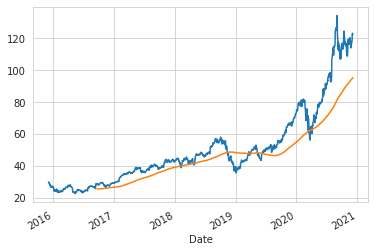

In [7]:
ticker = "AAPL" #@param {type:"string"}
# Plot the raw share-prices.
df_prices.loc[ticker, CLOSE].plot()

# Overlay plot of 200-day moving average.
df_prices.loc[ticker, CLOSE].rolling(window=200).mean().plot()

In [12]:
# Applying the price signals helper function to all stocks we have selected
df_price_signals = sf.apply(df=df_prices, func=price_signals)
df_price_signals.dropna()

MAVG 20  MAVG 200  ...  MACD-EMA  Relative Volume
Ticker Date                           ...                           
AAPL   2016-09-20  27.1520  25.52420  ...  0.340300        -0.233038
       2016-09-21  27.2110  25.51735  ...  0.377029        -0.207582
       2016-09-22  27.2935  25.51280  ...  0.412455        -0.363133
       2016-09-23  27.3580  25.50590  ...  0.436609         0.130753
       2016-09-26  27.4325  25.50245  ...  0.452076        -0.435146
...                    ...       ...  ...       ...              ...
XOM    2020-11-30  36.8505  41.54395  ...  1.079985         0.259784
       2020-12-01  37.0760  41.43705  ...  1.123533        -0.018852
       2020-12-02  37.4025  41.33505  ...  1.163404        -0.161394
       2020-12-03  37.7515  41.23680  ...  1.200537        -0.231872
       2020-12-04  38.1770  41.14955  ...  1.254724        -0.168345

[13793 rows x 8 columns]

In [13]:
df_price_signals.columns

Index(['MAVG 20', 'MAVG 200', 'Buy', 'Sell', 'EMA', 'MACD', 'MACD-EMA',
       'Relative Volume'],
      dtype='object')

# Growth Signal

In [ ]:
df_growth_signals = \
    sf.growth_signals(df_prices=df_prices,
                      df_income_ttm=df_income_ttm,
                      df_income_qrt=df_income_qrt,
                      df_balance_ttm=df_balance_ttm,
                      df_balance_qrt=df_balance_qrt,
                      df_cashflow_ttm=df_cashflow_ttm,
                      df_cashflow_qrt=df_cashflow_qrt,
                      fill_method='ffill')

In [17]:
df_growth_signals.dropna()

,Assets Growth,Assets Growth QOQ,Assets Growth YOY,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,FCF Growth QOQ,FCF Growth YOY,Sales Growth,Sales Growth QOQ,Sales Growth YOY
Date,,,,,,,,,,,,
2017-01-03,0.129080,0.029392,0.129080,-0.158456,0.984801,-0.025598,-0.142152,0.789316,0.015219,-0.071791,0.672309,0.032673
2017-01-04,0.129080,0.029392,0.129080,-0.158456,0.984801,-0.025598,-0.142152,0.789316,0.015219,-0.071791,0.672309,0.032673
2017-01-05,0.129080,0.029392,0.129080,-0.158456,0.984801,-0.025598,-0.142152,0.789316,0.015219,-0.071791,0.672309,0.032673
2017-01-06,0.129080,0.029392,0.129080,-0.158456,0.984801,-0.025598,-0.142152,0.789316,0.015219,-0.071791,0.672309,0.032673
2017-01-09,0.129080,0.029392,0.129080,-0.158456,0.984801,-0.025598,-0.142152,0.789316,0.015219,-0.071791,0.672309,0.032673
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-30,-0.043212,0.020621,-0.043212,0.039000,0.126189,-0.074017,0.245670,0.277846,0.096831,0.055121,0.083991,0.010275
2020-12-01,-0.043212,0.020621,-0.043212,0.039000,0.126189,-0.074017,0.245670,0.277846,0.096831,0.055121,0.083991,0.010275
2020-12-02,-0.043212,0.020621,-0.043212,0.039000,0.126189,-0.074017,0.245670,0.277846,0.096831,0.055121,0.083991,0.010275


,Assets Growth,Assets Growth QOQ,Assets Growth YOY,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,FCF Growth QOQ,FCF Growth YOY,Sales Growth,Sales Growth QOQ,Sales Growth YOY
count,12254.000000,14737.000000,12254.000000,12254.000000,14737.000000,12254.000000,12254.000000,14737.000000,12254.000000,12254.000000,14737.000000,12254.000000
mean,0.186380,0.042449,0.186380,1.991695,1.096028,-0.185801,0.019154,-0.422195,0.475306,0.139541,0.112998,0.136805
std,0.317771,0.104595,0.317771,21.542562,15.191815,4.478797,3.114853,2.663061,3.000598,0.234805,0.810125,0.306272
min,-0.181089,-0.178235,-0.181089,-105.480000,-22.011905,-38.410713,-26.699969,-18.328947,-9.778156,-0.535077,-0.979926,-0.987451
25%,0.000289,-0.008960,0.000289,-0.347171,-0.366038,-0.395683,-0.191866,-0.623227,-0.267349,0.013923,-0.056250,0.005577
50%,0.071660,0.017317,0.071660,0.055699,-0.060773,0.058447,0.066670,-0.141184,0.092352,0.066695,0.027022,0.066387
75%,0.267020,0.061196,0.267020,0.525174,0.331915,0.324249,0.284081,0.403037,0.432847,0.226579,0.106096,0.233925
max,1.809153,0.799822,1.809153,263.698113,163.126370,15.715054,22.337920,8.256769,24.037915,1.204111,10.357576,1.350617


## Financial Signals

In [18]:
df_fin_signals = sf.fin_signals(df_prices=df_prices,
                                df_income_ttm=df_income_ttm,
                                df_balance_ttm=df_balance_ttm,
                                df_cashflow_ttm=df_cashflow_ttm,
                                fill_method='ffill')

In [19]:
df_fin_signals.dropna().head()

(Dividends + Share Buyback) / FCF  ...  Share Buyback / FCF
Ticker Date                                           ...                     
TSLA   2015-12-31                           0.396699  ...             0.396699
       2016-01-04                           0.396699  ...             0.396699
       2016-01-05                           0.396699  ...             0.396699
       2016-01-06                           0.396699  ...             0.396699
       2016-01-07                           0.396699  ...             0.396699

[5 rows x 19 columns]

## Valuation Signals

In [20]:
df_val_signals = sf.val_signals(df_prices=df_prices,
                                df_income_ttm=df_income_ttm,
                                df_balance_ttm=df_balance_ttm,
                                df_cashflow_ttm=df_cashflow_ttm)

In [22]:
df_val_signals.dropna().head()

,Dividend Yield,Earnings Yield,FCF Yield,Market-Cap,P/Cash,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales,Price to Book Value
count,11099.000000,11099.000000,11099.000000,1.109900e+04,1.109900e+04,11099.000000,11099.000000,11099.000000,11099.000000,11099.000000,11099.000000
mean,0.029759,-0.081057,0.026573,2.914692e+11,inf,30.579719,29.415376,-7.774828,-0.580717,4.090336,2.569101
std,0.029769,0.988168,0.171060,3.018516e+11,NaN,41.774250,51.090219,48.890667,35.109831,3.690591,67.720387
min,0.001082,-17.515174,-3.440481,2.087790e+08,4.995908e-01,-144.660481,-122.573776,-395.686150,-218.081600,0.041482,-764.553388
25%,0.013359,0.027697,0.028323,1.350431e+11,1.211220e+01,17.896039,16.866300,-7.874452,-6.518487,1.956173,2.060102
50%,0.024973,0.040212,0.045386,2.252675e+11,1.857131e+01,23.535949,21.033490,-4.156590,-4.620614,3.628512,4.860713
75%,0.034761,0.049856,0.056853,3.425140e+11,3.141427e+01,30.337819,29.605351,-0.277557,-0.931711,4.649293,10.030708
max,0.327920,0.106783,0.327920,2.379609e+12,inf,312.837494,591.613096,127.916374,291.473179,27.321344,201.165774


## Compilation

We have the following signals:

1.   Price Signals (df_price_signals)
2.   Growth Signals (df_growth_signals)
3.   Financial Signals (df_fin_signals)
4.   Valuation Signals (df_val_signals) 

We will now export them as separate CSV's

In [23]:
df_price_signals.to_csv("price_signals")
df_growth_signals.to_csv("growth_signals")
df_fin_signals.to_csv("financial_signals")
df_val_signals.to_csv("valuation_signals")